In [1]:
!nvidia-smi

Fri May 13 15:27:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   50C    P8    37W / 350W |   1821MiB / 24267MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!. ../venv/bin/activate

/bin/bash: ../venv/bin/activate: No such file or directory


In [3]:
# !python3 -mpip install pip --upgrade
# !python3 -mpip install -r ./requirements.txt

In [4]:
from __future__ import print_function, division


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import copy
import json
import importlib
import glob
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np

import torch
# from sklearn.model_selection import train_test_split
from torch.optim import (
  Adam
)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from extra.utils import (
  load_config,
  _print,
)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## Global variables

In [5]:
CONFIG_NAME = "isic2018_unet.yaml"
CONFIG_FILE_PATH = os.path.join("./configs", CONFIG_NAME)

In [13]:
config = load_config(CONFIG_FILE_PATH)
_print("Config:", "info_underline")
print(json.dumps(config, indent=2))
print(20*"~-", "\n")

Config:
{
  "run": {
    "mode": "train",
    "device": "gpu"
  },
  "transforms": "none",
  "dataset": {
    "class_name": "ISIC2018Dataset",
    "training": {
      "params": {
        "root_dir": "/home/staff/azad/deeplearning/datasets/ISIC2018",
        "img_folder": "ISIC2018_Task1-2_Training_Input",
        "msk_folder": "ISIC2018_Task1_Training_GroundTruth",
        "img_filename_format": "ISIC_*.jpg",
        "msk_filename_format": "ISIC_*_segmentation.png",
        "transform_list": [
          "Resize((128, 128))",
          "Normalize()"
        ]
      }
    },
    "validation": {
      "params": {
        "root_dir": "/home/staff/azad/deeplearning/datasets/ISIC2018",
        "img_folder": "ISIC2018_Task1-2_Validation_Input",
        "msk_folder": "ISIC2018_Task1_Validation_GroundTruth",
        "img_filename_format": "ISIC_*.jpg",
        "msk_filename_format": "ISIC_*_segmentation.png",
        "transform_list": [
          "Resize((128, 128))",
          "Normalize()"
  

## Functions

In [7]:
def show_img_msk(img, msk, figsize=(8,4)):
    _, axs = plt.subplots(1, 2, figsize=figsize)
    x = img.squeeze().permute([1, 2, 0]).to('cpu').numpy().astype(np.float)
    y = msk.squeeze().detach().to('cpu').numpy().astype(np.float)
    
    axs[0].imshow(x)
    axs[1].imshow(y)
    plt.show()
    
    
def save_in_textfile(directory, **kwargs):
    os.makedirs(directory, exist_ok=True)
    for key in kwargs.keys():
        fn = f'{directory}/{key}.txt'
        with open(fn, 'w') as f:
            for e in kwargs[key]:
                f.write(str(e) + "\n")
    
    
def load_losses(directory):
    res = {}
    fns = glob.glob(f'{directory}/*losses*txt')
    for fn in fns:
        var_name = fn.split('/')[-1].split('.txt')[0]
        res[var_name] = np.loadtxt(fn)
    return res
     
    
def plot_loss_curves(tr, vl):
#     plt.figure(figsize=(12, 4))
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("DiceLoss")
    plt.plot(range(len(tr)), tr, 'r')
    plt.plot(range(len(vl)), vl, 'b')
    plt.legend(['Traning', 'Validation'])
    plt.show()

## Dataset and data-loader

In [8]:
from datasets import (
  ISIC2018Dataset
)

Dataset = globals()[config['dataset']['class_name']]
training_dataset = Dataset(**config['dataset']['training']['params'])
validation_dataset = Dataset(**config['dataset']['validation']['params'])

print(f"Length of trainig_dataset:\t{len(training_dataset)}")
print(f"Length of validation_dataset:\t{len(validation_dataset)}")

train_dataloader = DataLoader(training_dataset, **config['data_loader']['train'])
validation_dataloader = DataLoader(validation_dataset, **config['data_loader']['validation'])

Length of trainig_dataset:	2594
Length of validation_dataset:	100


## Model

In [29]:
from models.unet import Unet
from losses import DiceLoss


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Net = globals()[f"{config['model']['name']}"](**config['model']['params'])
Net.to(device)
print("Number of parameters:", sum(p.numel() for p in Net.parameters() if p.requires_grad))

tr_prms = config['training']

criterion = globals()[tr_prms['criterion']['name']](**tr_prms['criterion']['params'])
optimizer = globals()[tr_prms['optimizer']['name']](Net.parameters(), **tr_prms['optimizer']['params'])
# optimizer = optim.RMSprop(Net.parameters(), lr= float(config['lr']), weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

Number of parameters: 1946881


In [14]:
os.makedirs(config['model']['save_dir'], exist_ok=True)
model_path = f"{config['model']['save_dir']}/model_{CONFIG_NAME.split('.')[0]}"

if config['model']['load_weights']:
    Net.load_state_dict(torch.load(model_path))
    print("Loaded pre-trained weights...")

Loading pre-trained weights...


## Training

In [ ]:
print_every = 1
best_vl_loss = np.Inf

tr_itr_losses = [] # every 1-iteration 
tr_epoch_losses = [] # every 1-epoch
tr_epoch_loss = 0
tr_running_loss = 0

vl_itr_losses = [] # every 1-iteration 
vl_epoch_losses = [] # every 1-epoch
vl_epoch_loss = 0
vl_running_loss = 0

itrs = 0
for epoch in range(config['training']['epochs']//10):
    print(f'\nStarted epoch: {epoch:03d}...')
    
    # Trainig step
    print(' Trainig step:')
    tr_epoch_loss = 0
    Net.train()
    for itr, batch in enumerate(train_dataloader):
        imgs = batch['img'].to(device)
        msks = batch['msk'].to(device)
        
        optimizer.zero_grad()
        preds = Net.forward(imgs)
        loss = criterion(preds, msks)
        loss.backward()
        optimizer.step()
        
        tr_loss = loss.item()
        tr_epoch_loss += tr_loss
        tr_running_loss += tr_loss
        tr_itr_losses.append(tr_loss)
        if itrs%print_every == (print_every-1):
            training_step_loss = tr_running_loss/print_every
            print(f'  itr: {itrs:04d}, training_loss: {training_step_loss:0.5f}')
            tr_running_loss = 0.0
        itrs += 1
    avg_tr_loss = tr_epoch_loss/(itr+1)
    tr_epoch_losses.append(avg_tr_loss)
    
    # Validation step
    print(' Validation step:')
    vl_epoch_loss = 0
    Net.eval()
    for itr, batch in enumerate(validation_dataloader):
        imgs = batch['img'].to(device)
        msks = batch['msk'].to(device)
        preds = Net.forward(imgs)
        loss = criterion(preds, msks)
        vl_loss = loss.item()
        vl_epoch_loss += vl_loss
        vl_itr_losses.append(vl_loss)
        print(f'  batch: {itr:04d}, itr_vl_loss: {vl_loss:0.5f}')
    avg_vl_loss = vl_epoch_loss/(itr+1)
    print(f'\nEnd of epoch: {epoch:03d} -> tr_loss: {avg_tr_loss:0.5f}, vl_loss: {avg_vl_loss:0.5f}\n')
    vl_epoch_losses.append(avg_vl_loss)
    
    # Save losses in the file
    save_in_textfile()
    
    # Track best performance, and save the model's state
    if avg_vl_loss < best_vl_loss:
        print(f'Better weights were obtained. Improvement (loss): {best_vl_loss-avg_vl_loss:0.7f}')
        best_vl_loss = avg_vl_loss
        torch.save(Net.state_dict(), model_path)
        
    
    # Save losses in textfiles
    save_in_textfile(
        f"{config['model']['save_dir']}/losses",
        tr_itr_losses = tr_itr_losses,
        tr_epoch_losses = tr_epoch_losses,
        vl_itr_losses = vl_itr_losses,
        vl_epoch_losses = vl_epoch_losses)
    
    print(30*'-~')

In [27]:
# gt = msks
# gt = gt == torch.max(gt)
# print(msks.shape, gt.shape)
# # show_img_msk(imgs[0], gt[0])

# from extra.evaluation import get_sensitivity
# get_sensitivity(preds[0], msks[0])

<module 'numpy' from '/work/scratch/azad/anaconda3/envs/pytorch_cuda11/lib/python3.9/site-packages/numpy/__init__.py'>

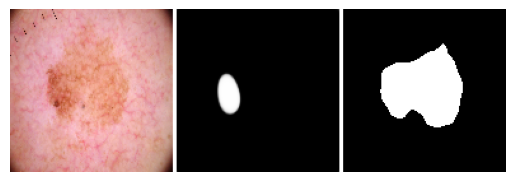

In [26]:
# def get_result_image(
#     model,
#     te_loader,
#     num_sample=12
# ):
Net.eval()
vertically=False
for itr, batch in enumerate(validation_dataloader):
    imgs = batch['img'].to(device)
    msks = batch['msk'].to(device)

    prds = Net.forward(imgs)
    
    for img, prd, msk in zip(imgs, msks, prds):
        img_np = img.squeeze().permute([1, 2, 0]).to('cpu').numpy().astype(np.float)
        prd_np = prd.squeeze().detach().to('cpu').numpy().astype(np.float)
        msk_np = msk.squeeze().detach().to('cpu').numpy().astype(np.float)
        
        s = msk_np.shape
        p = 3
        
        if vertically:
            # Vertically
            res = np.ones((s[0]*3+2*p, s[1], 3))
            res[0*s[0]+0*p:1*s[0]+0*p, :] = img_np
            res[1*s[0]+1*p:2*s[0]+1*p, :] = np.stack((msk_np,)*3, axis=-1)
            res[2*s[0]+2*p:3*s[0]+2*p, :] = np.stack((prd_np,)*3, axis=-1)
        else:
            # Horizontally
            res = np.ones((s[0], s[1]*3+2*p, 3))
            res[:, 0*s[0]+0*p:1*s[0]+0*p] = img_np
            res[:, 1*s[0]+1*p:2*s[0]+1*p] = np.stack((msk_np,)*3, axis=-1)
            res[:, 2*s[0]+2*p:3*s[0]+2*p] = np.stack((prd_np,)*3, axis=-1)

        break
    break
    
plt.figure()
plt.axis('off')
plt.imshow(res)
plt.show()

## Evaluation

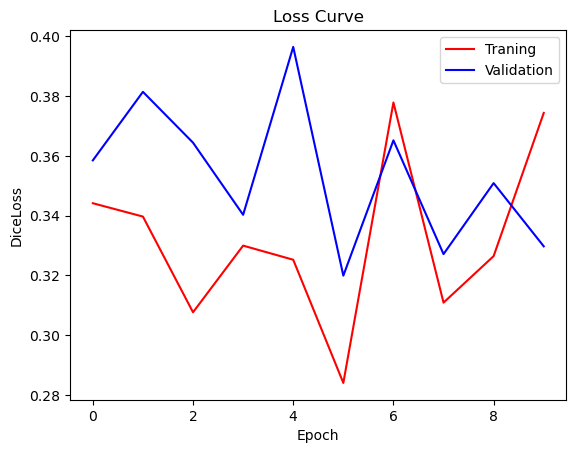

In [20]:
res = load_losses(f"{config['model']['save_dir']}/losses")
plot_loss_curves(res['tr_epoch_losses'], res['vl_epoch_losses'])

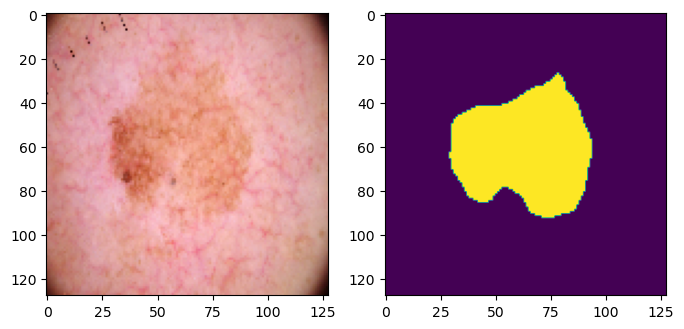

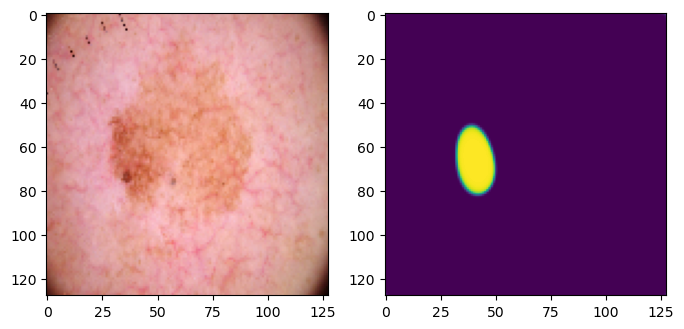

In [26]:
show_img_msk(imgs[0], msks[0])
show_img_msk(imgs[0], preds[0])